### This script was quick preliminary analysis / reivew of the data prior to constructing the running scripts

In [1]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import numpy as np
import time

import string
import pandas as pd
import gc

import warnings
import itertools

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from pandas.plotting import autocorrelation_plot

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
pd.set_option('display.float_format', lambda x:'%f'%x)

In [3]:
# function to display time
def print_elapsed_time(elapsed_time):
    if elapsed_time > 60:
        print('Time to Finish: '+str(elapsed_time/60) + ' min and ' + str(elapsed_time/(60*2)) + ' seconds' )
    else:
        print('Time to Finish: '+str(elapsed_time) + ' seconds')  
        
# Determine if the series is stationary or not
# Store in a function for later use!
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [4]:
# Default parameters
optionalPlotFunctionTS = 1

## Data Loading

In [5]:
# For main processing for comp
# imports
import pandas as pd
import numba
import numpy as np

import time
import datetime
from pandas.tseries.offsets import DateOffset
import math

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# set directory and files
directory = 'D:\\project\\data\\kg_corpgroc\\'
file_test = 'test.csv'
file_train = 'train.csv'

 # only read in id, date, store_nbr, item_nbr for now
# set the column data types
coltypes_train = {#'id':'float64',
            'id':'int64',
          #'t_date':'datetime64',
          'store_nbr':'int8',
           'item_nbr':'int32',
            'unit_sales':'float64',
            'promotion':'bool'
          }

coltypes_test = {#'id':'float64',
            'id':'int64',
          #'t_date':'datetime64',
          'store_nbr':'int8',
           'item_nbr':'int32',
            # 'unit_sales':'floag64'
            'promotion':'bool'
          }

start_time = time.time()
df_train = pd.read_csv(directory + file_train,dtype=coltypes_train,parse_dates=['date'],infer_datetime_format=True)
print_elapsed_time(time.time() - start_time)


start_time = time.time()
df_test = pd.read_csv(directory + file_test,dtype=coltypes_test,parse_dates=['date'],infer_datetime_format=True)
print_elapsed_time(time.time() - start_time)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Time to Finish: 1.781675895055135 min and 0.8908379475275675 seconds
Time to Finish: 2.6703579425811768 seconds


In [6]:
# Load th oil + holiday data sets
df_oil = pd.read_csv(directory + 'oil.csv')
df_holiday = pd.read_csv(directory + 'holidays_events.csv')

## Data Massaging

In [7]:
# Set the index to the date time
df_train.set_index('date',inplace=True)
df_test.set_index('date',inplace=True)

# Filter the data.  We are only pulling back from August of last year for now
df_train = df_train["2016-08-01":]

# now Order the data for being clean
df_train.sort_values(['store_nbr','item_nbr'], ascending=[True, True], inplace=True)

# Re-initialize variables for function below
idx = pd.DataFrame(pd.date_range('2016-08-01','2017-09-01'), columns={'dateRange'})
idx.set_index('dateRange',inplace=True)

In [8]:
df_train[(df_train['store_nbr']==1) & (df_train['item_nbr']==159156)].head(10)

,id,store_nbr,item_nbr,unit_sales,onpromotion
date,,,,,
2016-08-01,86672280,1,159156,18.341000,False
2016-08-02,86775022,1,159156,16.742000,False
2016-08-03,86874843,1,159156,14.994000,False
2016-08-04,86973851,1,159156,10.564000,False
2016-08-05,87068943,1,159156,12.611000,True
2016-08-06,87165150,1,159156,6.653000,False
2016-08-07,87267895,1,159156,4.385000,False
2016-08-08,87370283,1,159156,8.525000,False
2016-08-09,87467183,1,159156,8.701000,False


In [9]:
# Here test 
#20
#96995
len(df_train[(df_train['store_nbr']==20) & (df_train['item_nbr']==96995)])

0

In [10]:
# p - is the auto regresive, how likely would it be warm if the past three dys had been warm
# d - is the intergrated part.  How much differencing
# q - moving average

## Plotting and Review of samples

In [11]:
# Function to add additional ts analysis variables
def ts_add_col_features(store_nbr, item_nbr):
    
    # filter
    df = df_train[(df_train['store_nbr']==1) & (df_train['item_nbr']==96995)].copy()
    
    # Set frequency
    df = df.asfreq('D')
    
    # default imputed values
    df['id'].replace({np.nan: 0}, inplace=True)
    df['item_nbr'].replace({np.nan: item_nbr}, inplace=True)
    df['store_nbr'].replace({np.nan: store_nbr}, inplace=True)
    df['unit_sales'].replace({np.nan: 0}, inplace=True)
    df['onpromotion'].replace({np.nan: False}, inplace=True)
    
    # cycle and trend
    sales_cycle, sales_trend = sm.tsa.filters.hpfilter(df.unit_sales)
    df["cycle"] = sales_cycle
    df["trend"] = sales_trend
    
    # Simple moving average
    df["3-day-SMA"] = df['unit_sales'].rolling(window=3).mean()
    df["7-day-SMA"] = df['unit_sales'].rolling(window=7).mean()
    df["14-day-SMA"] = df['unit_sales'].rolling(window=14).mean()
    df["31-day-SMA"] = df['unit_sales'].rolling(window=31).mean()
    
    # EWMA
    df['EWMA_7_days'] = df['unit_sales'].ewm(span=7).mean()
    df['EWMA_14_days'] = df['unit_sales'].ewm(span=14).mean()
    df['EWMA_31_days'] = df['unit_sales'].ewm(span=31).mean()
    
    return df

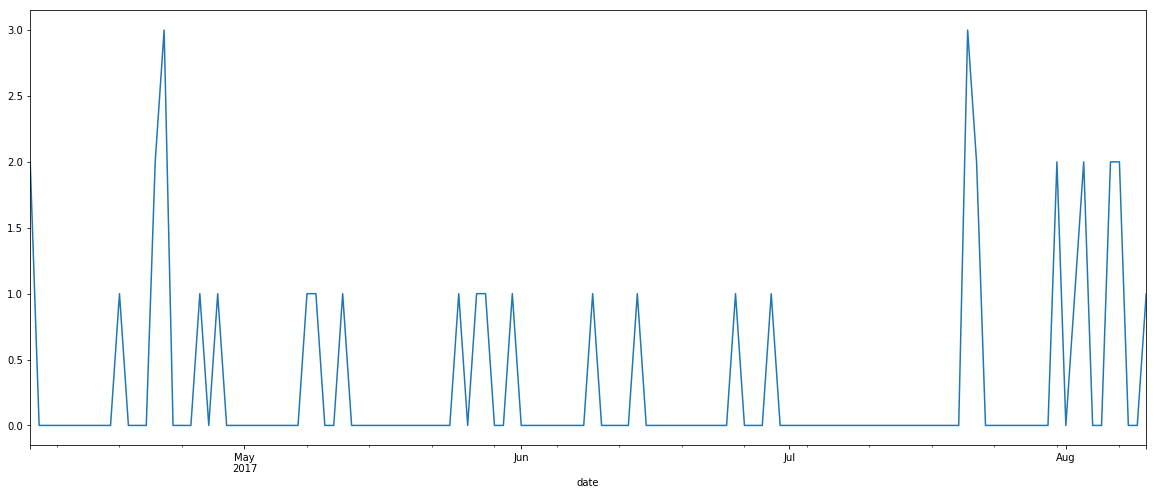

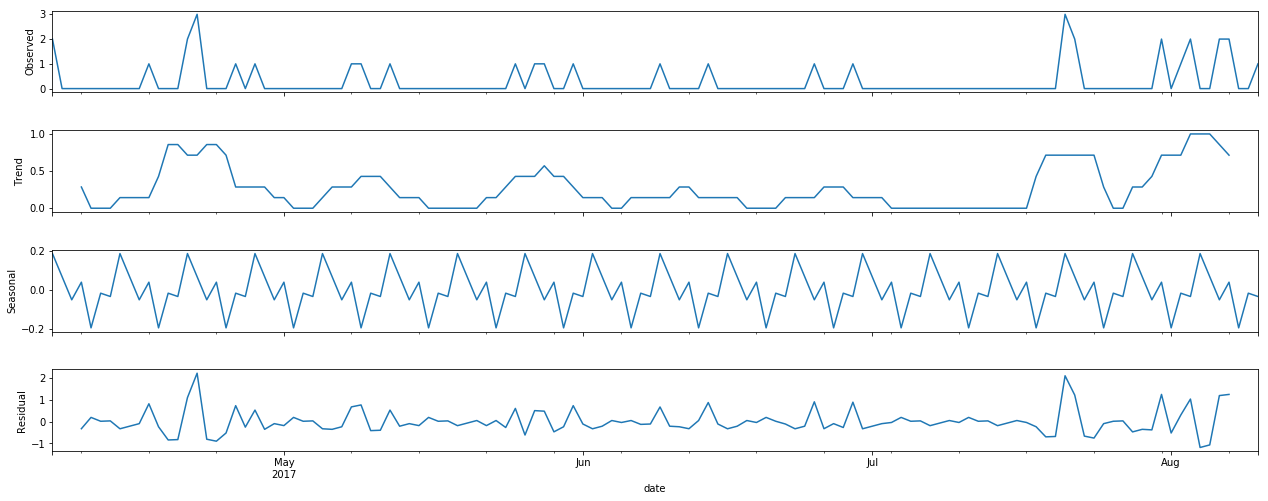

In [12]:
# Grab for restaraunt #1 and item #96995
sample1 = ts_add_col_features(1, 96995)

# basic plot
sample1['unit_sales'].plot(figsize=(20,8))

decomposition1 = seasonal_decompose(sample1.unit_sales, freq=7)
fig = plt.figure()
fig = decomposition1.plot()
fig.set_size_inches(20,8)
# Sesonal looks every 7 days

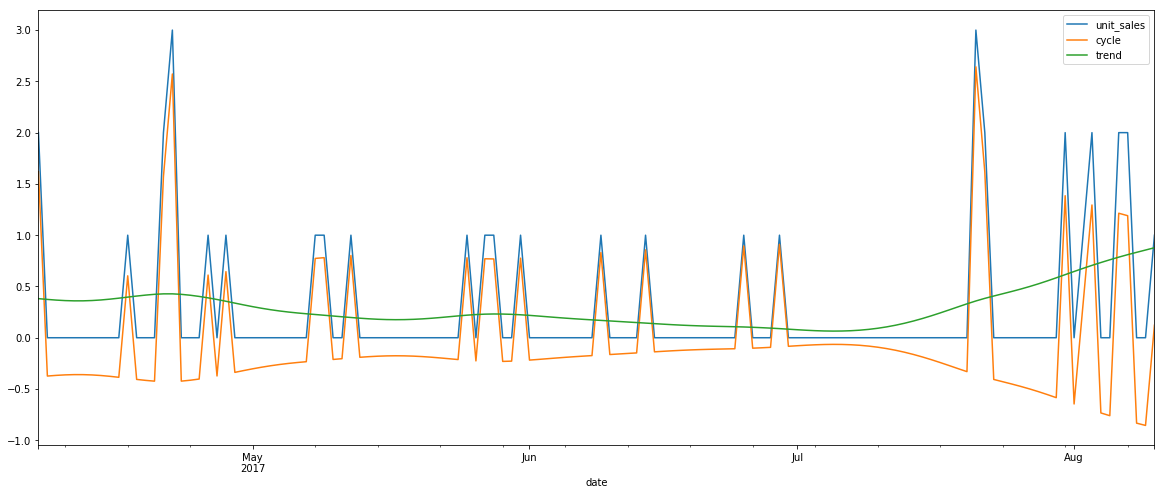

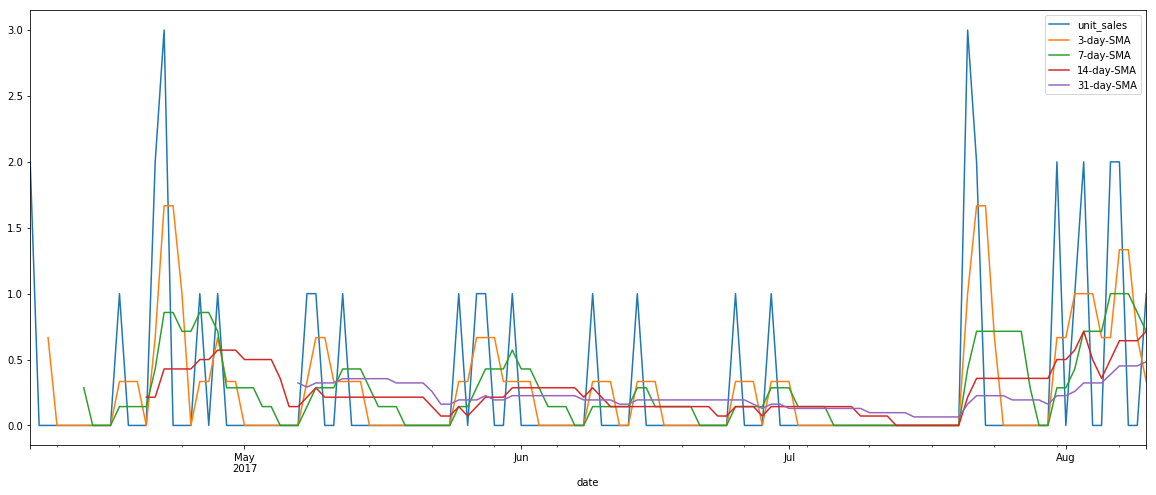

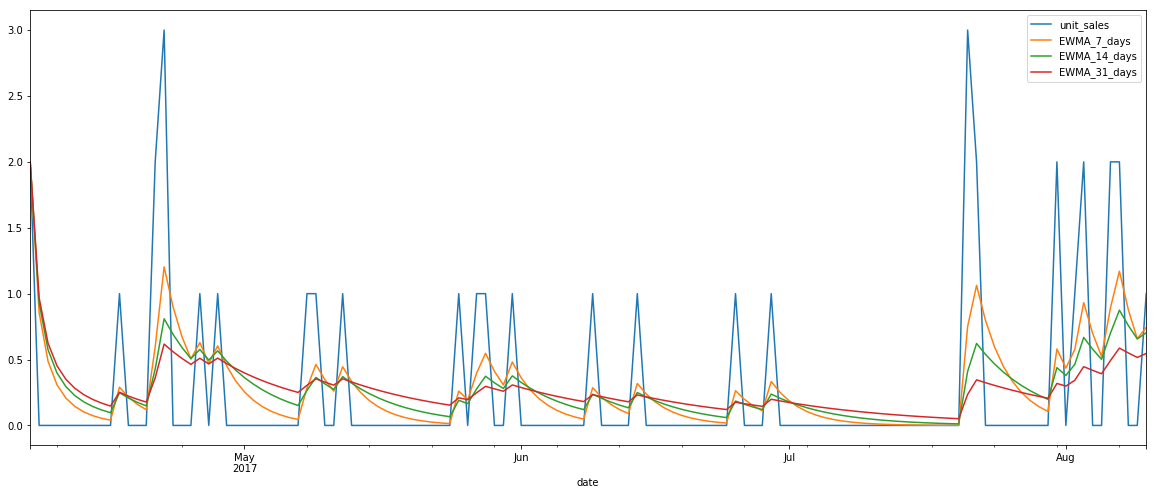

In [13]:
sample1[['unit_sales','cycle','trend']].plot(figsize=(20,8))
sample1[['unit_sales','3-day-SMA','7-day-SMA','14-day-SMA','31-day-SMA']].plot(figsize=(20,8))
sample1[['unit_sales','EWMA_7_days','EWMA_14_days','EWMA_31_days']].plot(figsize=(20,8))

In [14]:
adf_check(sample1['unit_sales'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.64534994413
p-value : 1.01433954465e-06
#Lags Used : 2
Number of Observations Used : 123
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


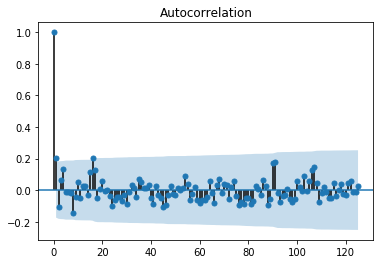

In [15]:
plot = plot_acf(sample1['unit_sales'].dropna())

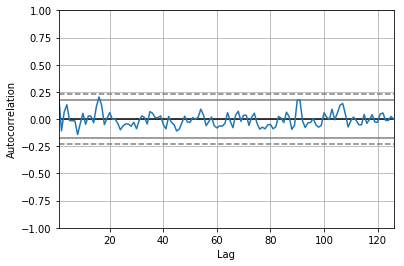

In [16]:
autocorrelation_plot(sample1['unit_sales'].dropna())

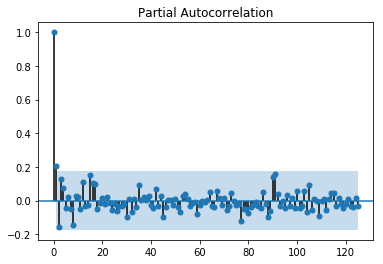

In [17]:
# partial auto-correlation
plot = plot_pacf(sample1['unit_sales'].dropna())

#### Testing / playing with multiple paramters to see which one generates the better scores.  

In [18]:
# orig from samples
model1 = sm.tsa.statespace.SARIMAX(sample1['unit_sales'],order=(0,1,0), seasonal_order=(1,1,1,12))


model2 = sm.tsa.statespace.SARIMAX(sample1['unit_sales'],order=(0,0,0), seasonal_order=(1,1,1,3))
model3 = sm.tsa.statespace.SARIMAX(sample1['unit_sales'],order=(1,0,0), seasonal_order=(1,1,1,3))
model4 = sm.tsa.statespace.SARIMAX(sample1['unit_sales'],order=(1,1,0), seasonal_order=(1,1,1,3))
#model5 = sm.tsa.statespace.SARIMAX(sample1['unit_sales'],order=(1,1,1), seasonal_order=(1,1,1,3))
model6 = sm.tsa.statespace.SARIMAX(sample1['unit_sales'],order=(1,0,1), seasonal_order=(1,1,1,3))

results6 = model6.fit()
# cannot fit #31


model7 = sm.tsa.statespace.SARIMAX(sample1['unit_sales'],order=(0,0,0), seasonal_order=(1,1,1,7))
model8 = sm.tsa.statespace.SARIMAX(sample1['unit_sales'],order=(1,0,0), seasonal_order=(1,1,1,7))
model9 = sm.tsa.statespace.SARIMAX(sample1['unit_sales'],order=(1,1,0), seasonal_order=(1,1,1,7))
model10 = sm.tsa.statespace.SARIMAX(sample1['unit_sales'],order=(1,1,1), seasonal_order=(1,1,1,7))
model11 = sm.tsa.statespace.SARIMAX(sample1['unit_sales'],order=(1,0,1), seasonal_order=(1,1,1,7))
results7 = model7.fit()
results8 = model8.fit()
results9 = model9.fit()
#results10 = model10.fit() # Erroring
results11 = model11.fit()


results1 = model1.fit()
print(results1.summary())
print('\n ---==========================================================================---')
print('\n ---==========================================================================---')
results2 = model2.fit()
print(results2.summary())
print('\n ---==========================================================================---')
print('\n ---==========================================================================---')
results3 = model3.fit()
print(results3.summary())
print('\n ---==========================================================================---')
print('\n ---==========================================================================---')
results4 = model4.fit()
print(results4.summary())
print('\n ---==========================================================================---')
print('\n ---==========================================================================---')
#results5 = model5.fit()
#print(results5.summary())
print('\n ---==========================================================================---')
print('\n ---==========================================================================---')
results5 = model6.fit()
print(results5.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         unit_sales   No. Observations:                  126
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -146.834
Date:                            Wed, 10 Jan 2018   AIC                            299.668
Time:                                    22:31:21   BIC                            308.177
Sample:                                04-07-2017   HQIC                           303.125
                                     - 08-10-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0458      0.198     -0.231      0.817      -0.434       0.342
ma.S.L12      -0.6984      0.236   

                                 Statespace Model Results                                
Dep. Variable:                        unit_sales   No. Observations:                  126
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 3)   Log Likelihood                -121.318
Date:                           Wed, 10 Jan 2018   AIC                            252.635
Time:                                   22:31:22   BIC                            266.817
Sample:                               04-07-2017   HQIC                           258.397
                                    - 08-10-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2138      0.420     -0.509      0.610      -1.036       0.609
ma.L1          0.4964      0.392      1.266

In [19]:
print(results5.aic)
print(results5.model.order)
print(results5.model.seasonal_order)
print(results5.model.seasonal_periods)

252.635240507
(1, 0, 1)
(1, 1, 1, 3)
3


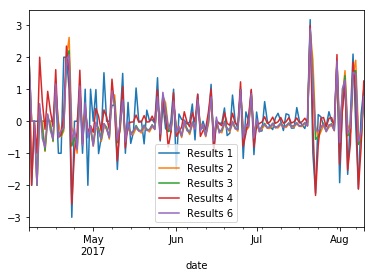

In [20]:
results1.resid.plot(legend=True, label='Results 1')
results2.resid.plot(legend=True, label='Results 2')
results3.resid.plot(legend=True, label='Results 3') # looks the best??
results4.resid.plot(legend=True, label='Results 4')
#results5.resid.plot(legend=True, label='Results 31')
results6.resid.plot(legend=True, label='Results 6')

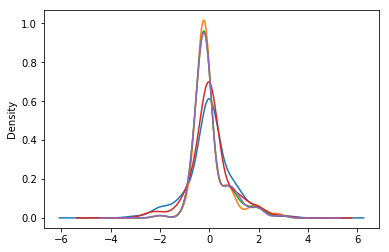

In [21]:
results1.resid.plot(kind='kde', label='Results 1')
results2.resid.plot(kind='kde', label='Results 2') # looks best
results3.resid.plot(kind='kde', label='Results 3')
results4.resid.plot(kind='kde', label='Results 4')
#results5.resid.plot(kind='kde', label='Results 31')
results6.resid.plot(kind='kde', label='Results 6')

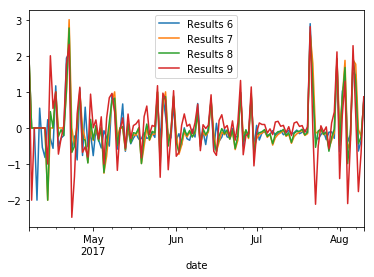

In [22]:
results6.resid.plot(legend=True, label='Results 6')
results7.resid.plot(legend=True, label='Results 7')
results8.resid.plot(legend=True, label='Results 8') # looks the best??
results9.resid.plot(legend=True, label='Results 9')
#results10.resid.plot(legend=True, label='Results 10')

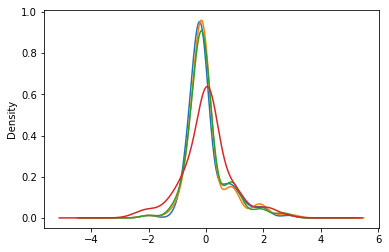

In [23]:
results6.resid.plot(kind='kde', label='Results 6')
results7.resid.plot(kind='kde', label='Results 7') # still looks the best
results8.resid.plot(kind='kde', label='Results 8')
results9.resid.plot(kind='kde', label='Results 9')
#results10.resid.plot(kind='kde', label='Results 10')

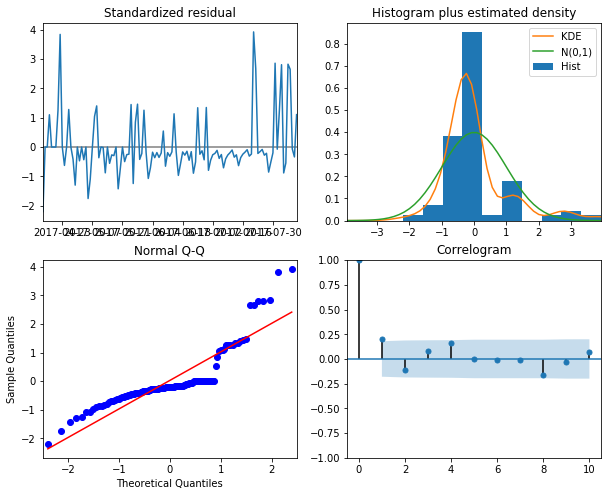

In [24]:
# Plot diagnostics on the two better looking items

ben = results7.plot_diagnostics(figsize=(10,8))

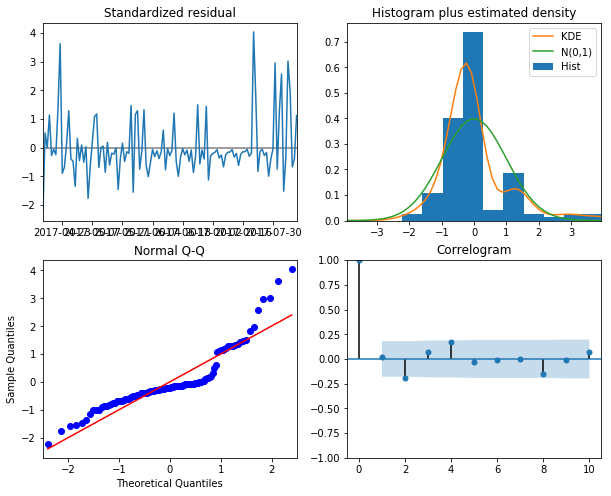

In [25]:
ben = results8.plot_diagnostics(figsize=(10,8))

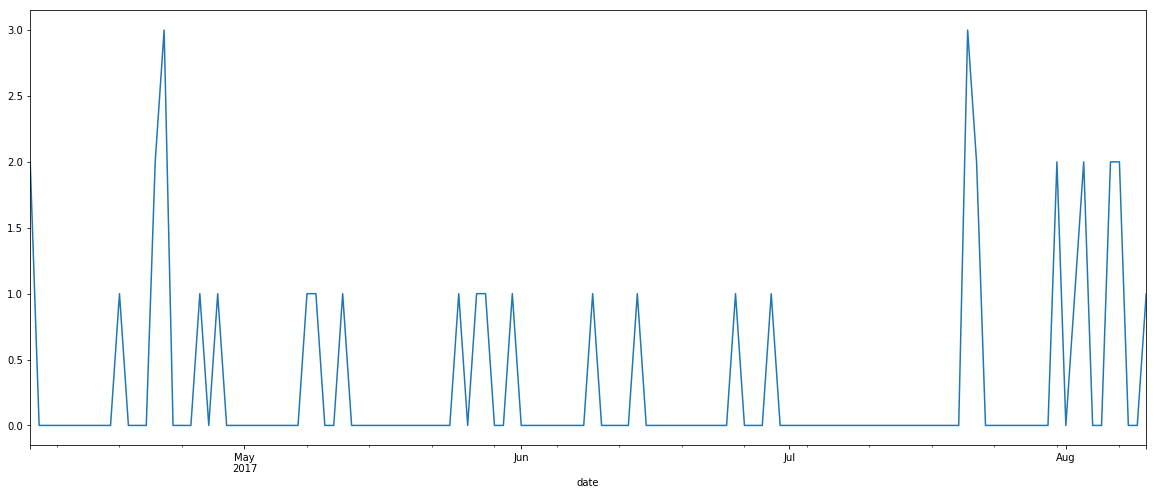

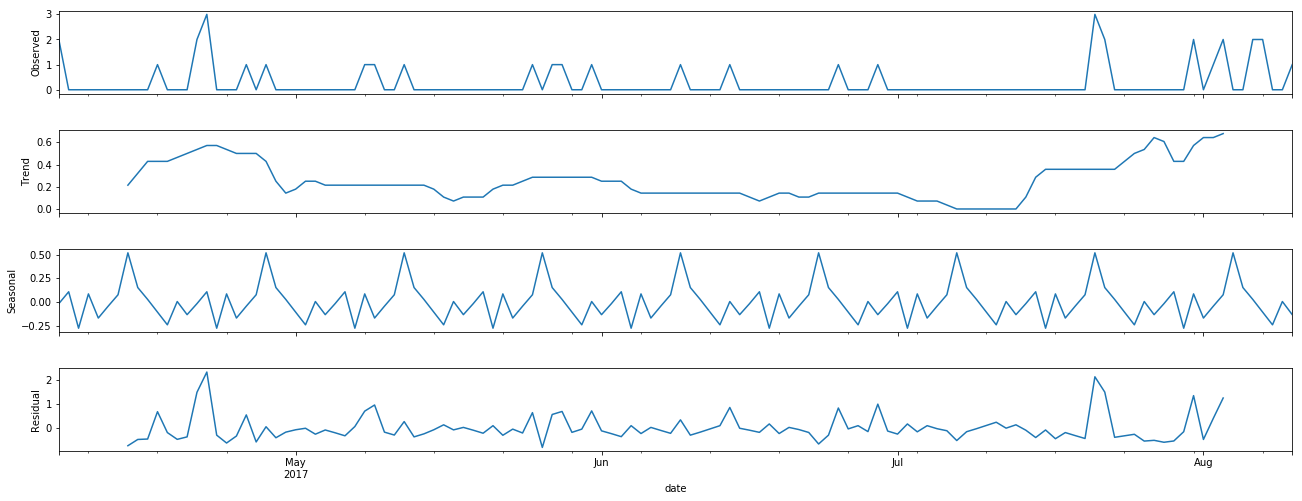

In [26]:
# Set a the sample to look at the seasonal decomposition
sample2 = ts_add_col_features(1, 843609)

sample2['unit_sales'].plot(figsize=(20,8))

decomposition1 = seasonal_decompose(sample2.unit_sales, freq=14)
fig = plt.figure()
fig = decomposition1.plot()
fig.set_size_inches(20,8)

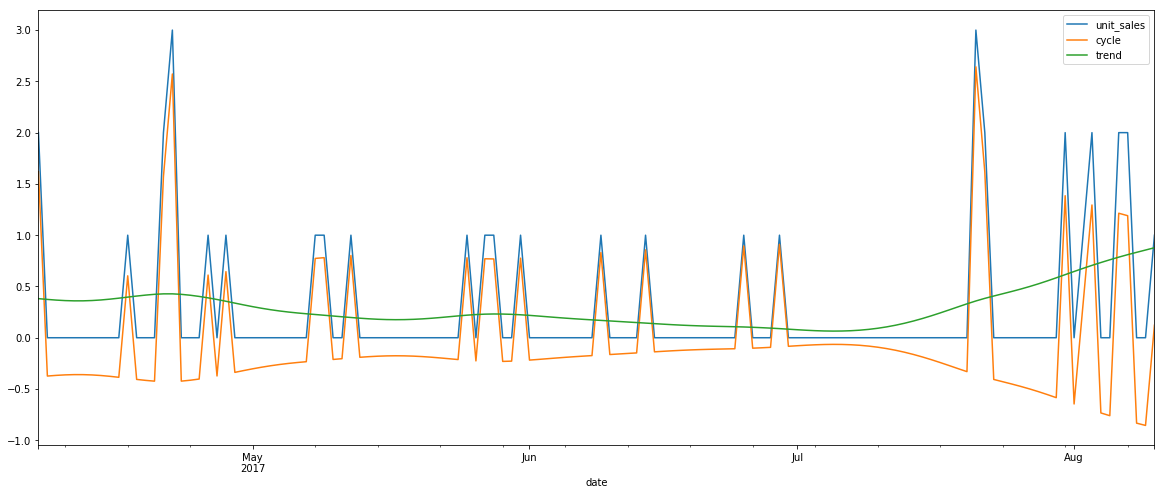

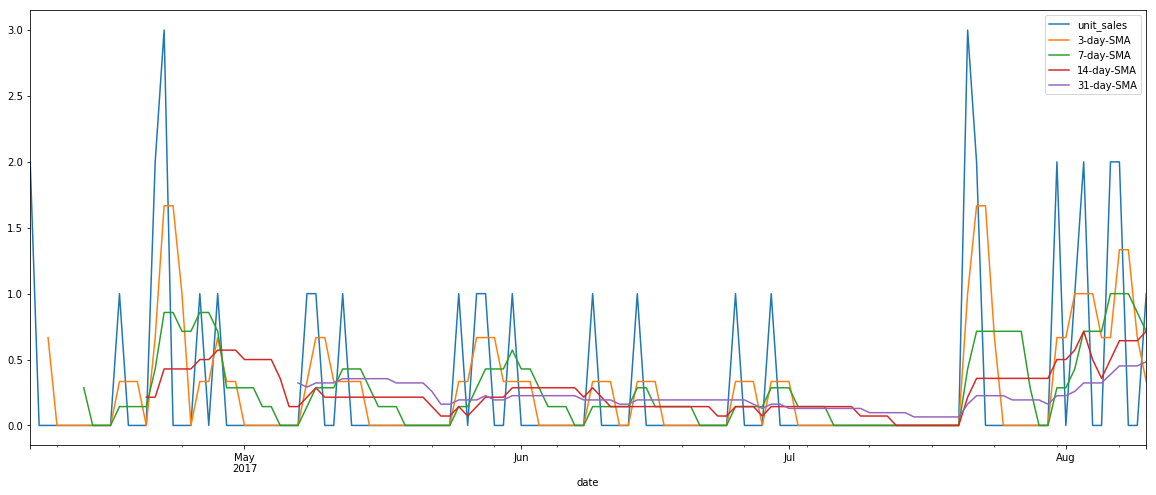

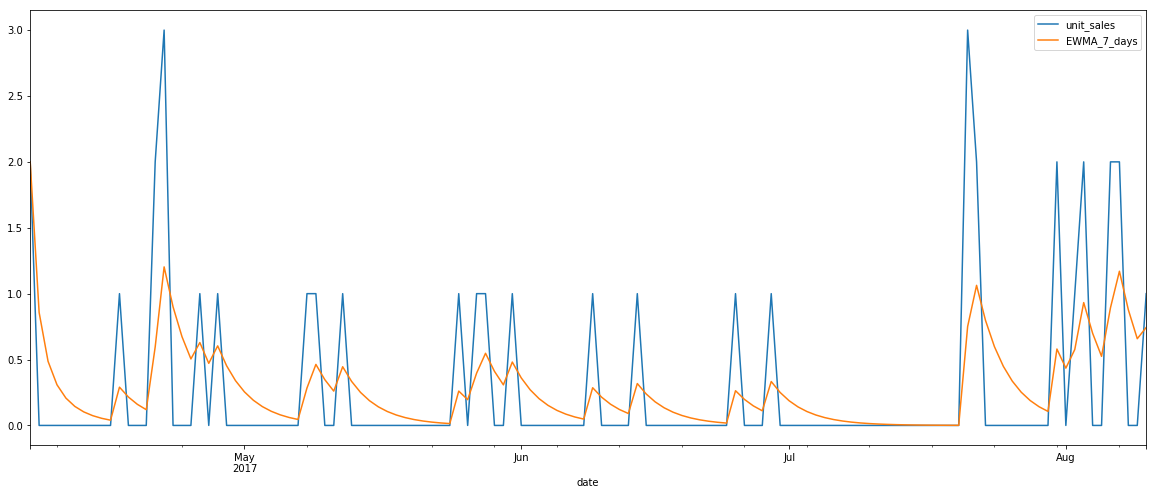

In [27]:
sample2[['unit_sales','cycle','trend']].plot(figsize=(20,8))
sample2[['unit_sales','3-day-SMA','7-day-SMA','14-day-SMA','31-day-SMA']].plot(figsize=(20,8))
sample2[['unit_sales','EWMA_7_days']].plot(figsize=(20,8))

In [28]:
adf_check(sample2['unit_sales'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.64534994413
p-value : 1.01433954465e-06
#Lags Used : 2
Number of Observations Used : 123
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


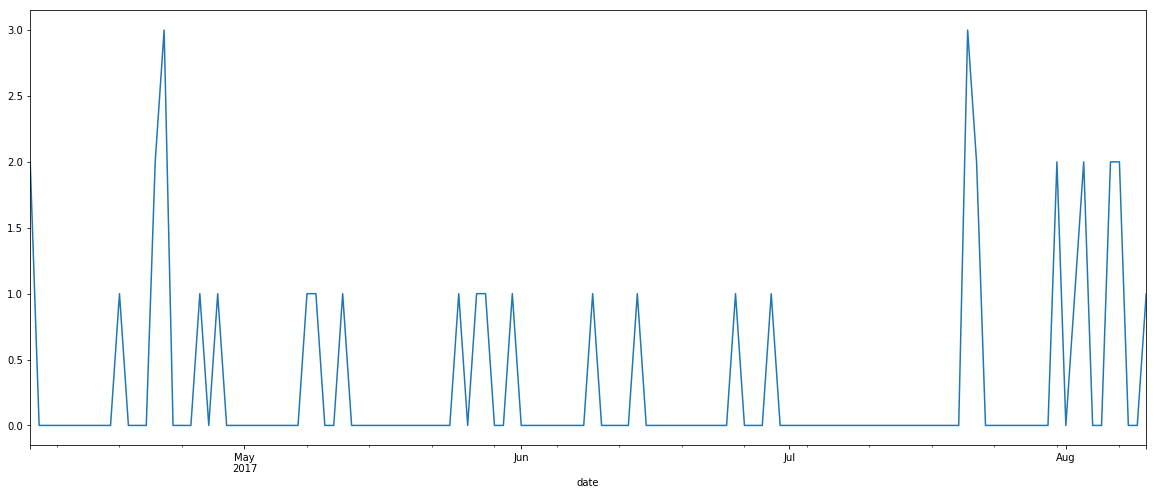

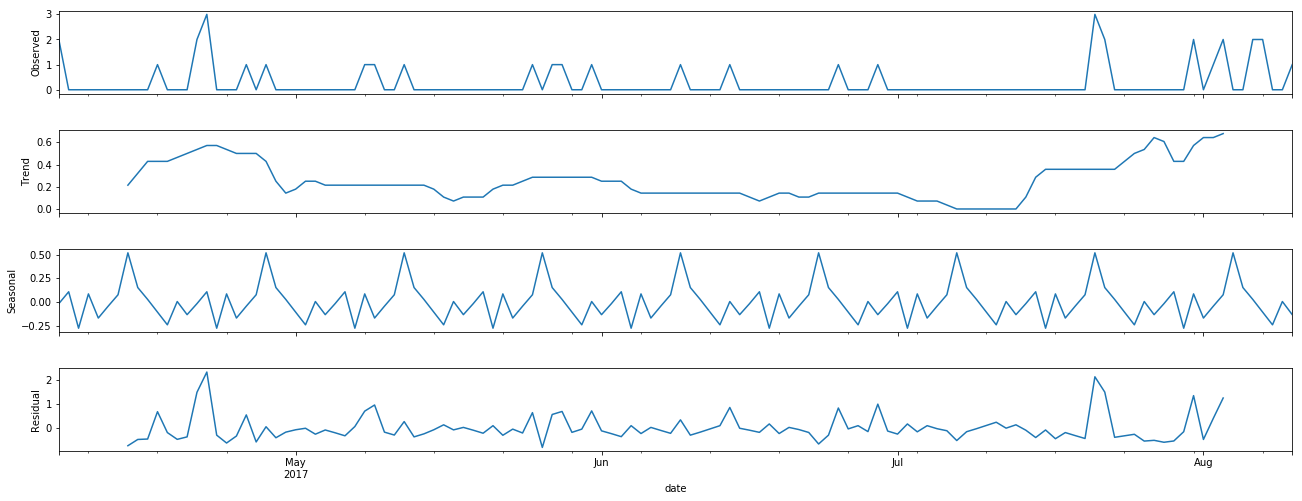

In [29]:
# Set the sample
sample3 = ts_add_col_features(1, 2114812)

sample3['unit_sales'].plot(figsize=(20,8))

decomposition3 = seasonal_decompose(sample3.unit_sales, freq=14)
fig = plt.figure()
fig = decomposition1.plot()
fig.set_size_inches(20,8)

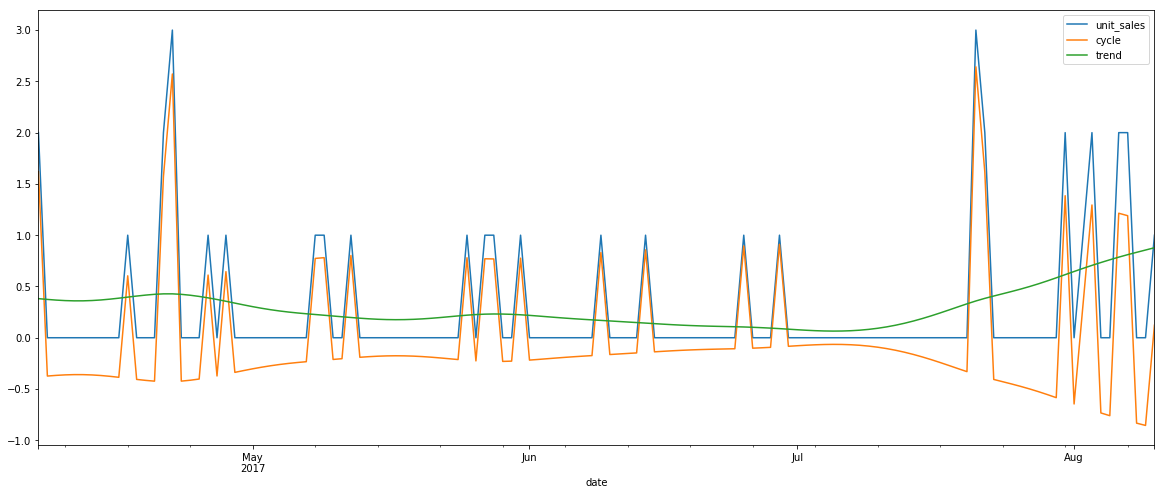

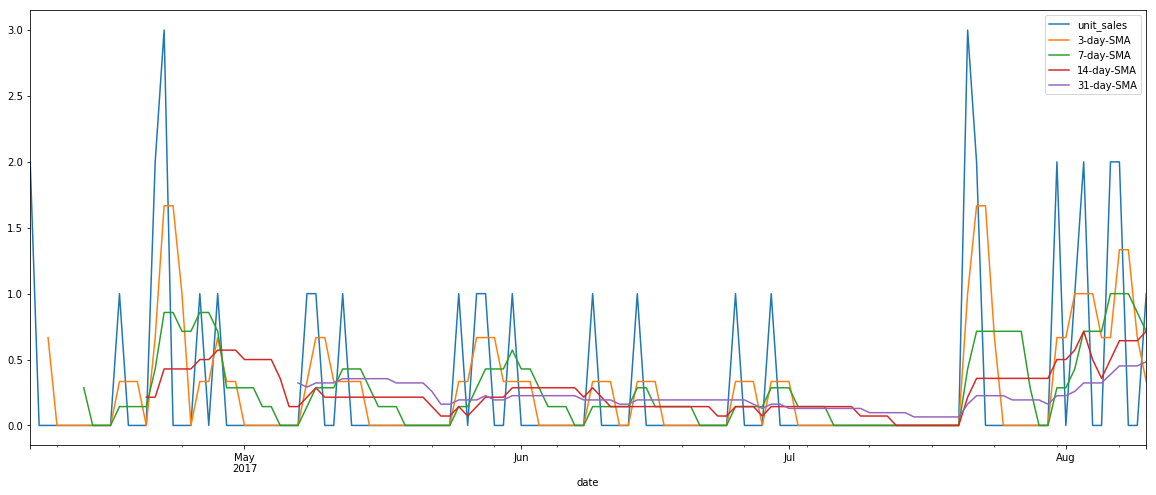

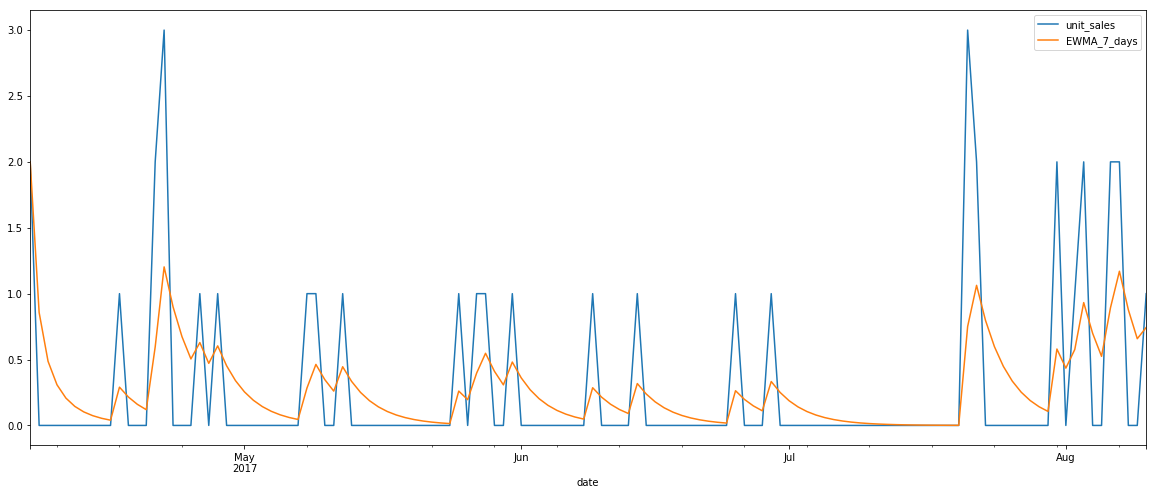

In [30]:
sample3[['unit_sales','cycle','trend']].plot(figsize=(20,8))
sample3[['unit_sales','3-day-SMA','7-day-SMA','14-day-SMA','31-day-SMA']].plot(figsize=(20,8))
sample3[['unit_sales','EWMA_7_days']].plot(figsize=(20,8))

In [31]:
adf_check(sample3['unit_sales'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.64534994413
p-value : 1.01433954465e-06
#Lags Used : 2
Number of Observations Used : 123
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


## Running / Testing some time series predictions on a couple of samples

In [33]:
# def config_time_Series(storeNumber, itemNumber, ts_order, ts_seasonal_order, start_predict):
def fn_attemptTimeSeriesParamConfig(args):

    warnings.filterwarnings("ignore") # specify to ignore warning messages
    
    # Constants for data existing or not
    CONST_DATA_EXISTS = 'YES'
    CONST_NO_DATA_EXISTS = 'NO'
    CONST_ERROR_EXISTS = 'ERROR'
    
    # Need to split up the args
    # ensure prefixed with arg_ to avoid other test items
    arg_storeNumber = args[0]
    arg_itemNumber = args[1]
    arg_ts_order = args[2]
    arg_ts_seasonal_order = args[3]
    arg_start_predict = args[4]

    # filter the TS criteria
    dfTS = df_train[(df_train['store_nbr'] == arg_storeNumber) & (df_train['item_nbr'] == arg_itemNumber)].copy()

    # Set a default list in case the TS errors
    param_diag_list = [arg_storeNumber, arg_itemNumber, CONST_ERROR_EXISTS, arg_ts_order, arg_ts_seasonal_order, 0, 0, 0, 0, 0]
    
    # If there is no data to plot then exit
    if len(dfTS) > 0:
    
        # Imput the missing dates going all the way back
        dfTS = pd.concat([dfTS,idx], axis=1)
        dfTS = dfTS.asfreq('D')

        # When we joined to dates, now replace everything else for the single unit we are working on
        dfTS['id'].replace({np.nan: 0}, inplace=True)
        dfTS['item_nbr'].replace({np.nan: arg_itemNumber}, inplace=True)
        dfTS['store_nbr'].replace({np.nan: arg_storeNumber}, inplace=True)
        dfTS['unit_sales'].replace({np.nan: 0}, inplace=True)
        dfTS['onpromotion'].replace({np.nan: False}, inplace=True)

        sales_cycle, sales_trend = sm.tsa.filters.hpfilter(dfTS.unit_sales)
        dfTS['trend'] = sales_trend
        dfTS['cycle'] = sales_cycle


        # if we hit an error trying to perform a TS analysis, then skip over it in the paramater seraching
        # try:
        
        # the forecasting
        model = sm.tsa.statespace.SARIMAX(dfTS['unit_sales'], order=arg_ts_order, seasonal_order=arg_ts_seasonal_order,
                                          enforce_stationarity=False, enforce_invertibility=False)
        #model = sm.tsa.statespace.SARIMAX(dfTS['unit_sales'], order=(1,2,0), seasonal_order=(1,1,1,7))
        results = model.fit()

        # for 2013-01-01 to current.  Use 1600 / 2150
        # for 2016-08-01 to current.  Use 0 / 396
        # for 2017-06-01 to current.  Use 300 / 396
        dfTS['forecast'] = results.predict(start = arg_start_predict, end = 396)  #, dynamic=True


        # Not sure if I should keep this here
        #dfTS['forecast'] = (dfTS['forecast'].shift(-1)) or +1
        dfTS.drop(dfTS.index[len(dfTS)-1], inplace=True)

        dfTS['cycle_rnd'] = dfTS['cycle'].apply(math.ceil)
        dfTS['forecast_rnd'] = dfTS['forecast']
        dfTS['forecast_rnd'].replace({np.nan: 0}, inplace=True)
        dfTS['forecast_rnd'] = dfTS['forecast_rnd'].apply(math.ceil)
        # dfTS['forecast_sq'] = dfTS['forecast_rnd'] * dfTS['forecast_rnd']

        # Configure MSE
        # grabbing dates from 2017-06-01 to 2017-08-14, which lines up close to a start date of 300
        y = dfTS['unit_sales']["2017-06-01":"2017-08-14"]
        y_frcast = dfTS['forecast']["2017-06-01":"2017-08-14"]
        y_frcast_rnd = dfTS['forecast_rnd']["2017-06-01":"2017-08-14"]

        mse_frcast = ((y_frcast - y) ** 2).mean()
        mse_frcast_rnd = ((y_frcast_rnd - y) ** 2).mean()

        sse_frcast = ((y_frcast - y) ** 2).sum()
        sse_frcast_rnd = ((y_frcast_rnd - y) ** 2).sum()

        # Here we need to record the following:
        # 1) store_nbr
        # 2) item_nbr
        # 3) full param set
        # 4) AIC from the model
        #    SME from the days of Aug 01 - Aug 14.
        # 5) SME from regular forecast
        # 6) SME from forecast rounded to nearest whole unit
        #print(mse_frcast)
        #print(mse_frcast_rnd)
        #print(results.aic)
        #print(results.model.order)
        #print(results.model.seasonal_order)
        #print(results.model.seasonal_periods)

        # Set the parameter list
        param_diag_list = [arg_storeNumber, arg_itemNumber, CONST_DATA_EXISTS, arg_ts_order, arg_ts_seasonal_order, results.aic, mse_frcast, mse_frcast_rnd, sse_frcast, sse_frcast_rnd]

        # plot - need to make this optional
        if optionalPlotFunctionTS==1:
            dfTS[['unit_sales', 'forecast_rnd']]["2017-06-01":].plot(figsize=(12, 8))
        #return dfTS
            
        # If we hit an error, continue on
        #except:
        #    pass
        
    # ELSE
    else:
        #print('nothing')
        # set a blank diag list with a constant of no data existing
        param_diag_list = [arg_storeNumber, arg_itemNumber, CONST_NO_DATA_EXISTS, arg_ts_order, arg_ts_seasonal_order, 0, 0, 0, 0, 0]
    
    # END IF STATEMENT
    
    # Turn the list into a data frame
    colNames=('store_nbr','item_nbr','data_present','model_order','model_seasonal_order','model_aic','mse_frcst','mse_frcst_rnd','sse_frcst','sse_frcst_rnd')
    df_param_diag = pd.DataFrame(param_diag_list).T
    df_param_diag.columns = colNames
    
    # return the data frame
    return df_param_diag

In [34]:
# Concatenating a bunch of data to prepare to pass into functions
def fn_concat_args(input_store_nbr, input_item_nbr, input_ts_order, input_ts_seasonal_order, input_start_predict):
    '''
        temp_store_nbr = 1
        temp_item_nbr = 96995
        temp_ts_order=(1,1,0)
        temp_ts_seasonal_order=(0,0,0,14)
        temp_start_predict = 300
    '''
    
    args = [[input_store_nbr,input_item_nbr,input_ts_order,input_ts_seasonal_order,input_start_predict]]
    return args

In [35]:
# 01/01/2018 - Taking n example to look at AIC, MSE, and Shifting
# Will try another round by MSE, rather than 
# WITHOUT SHIFT turned the same AIC, but less MSE

,store_nbr,item_nbr,data_present,model_order,model_seasonal_order,model_aic,mse_frcst,mse_frcst_rnd,sse_frcst,sse_frcst_rnd
0,1,1463610,YES,"(0, 1, 1)","(1, 1, 1, 14)",1429.908845,2.305787,2.666667,172.934016,200.000000


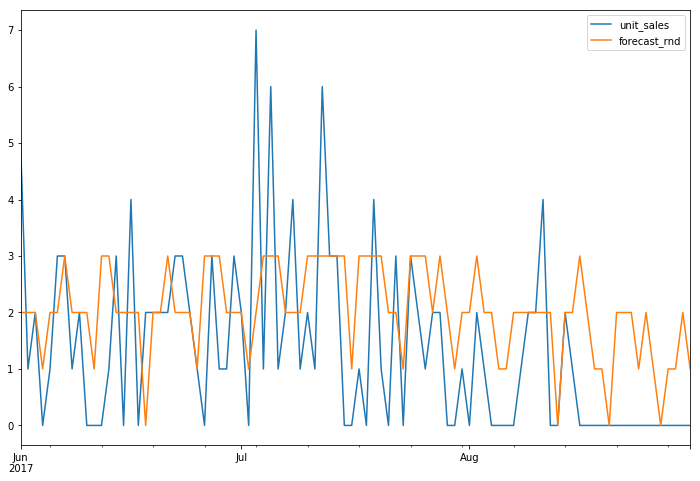

In [36]:
# 01/01/2018 - look at this one
temp_store_nbr = 1
temp_item_nbr = 1463610
temp_start_predict = 300  

# lowest AIC 
temp_ts_order=(0, 1, 1)
temp_ts_seasonal_order=(1, 1, 1, 14)

args = [[temp_store_nbr,temp_item_nbr,temp_ts_order,temp_ts_seasonal_order,temp_start_predict]]
optionalPlotFunctionTS = 1
parmDF = fn_attemptTimeSeriesParamConfig(args[0])
parmDF.head()

,store_nbr,item_nbr,data_present,model_order,model_seasonal_order,model_aic,mse_frcst,mse_frcst_rnd,sse_frcst,sse_frcst_rnd
0,1,1463610,YES,"(1, 0, 1)","(0, 1, 1, 7)",1460.417784,2.184906,2.533333,163.867922,190.000000


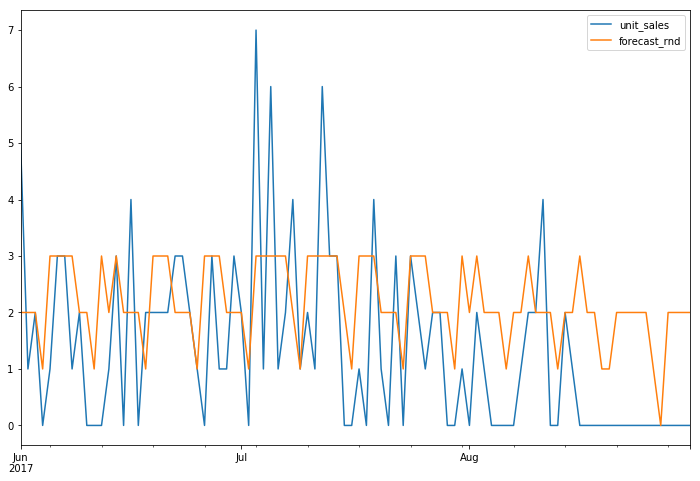

In [37]:
# 01/01/2018 - Lowest MSE
temp_ts_order=(1, 0, 1)
temp_ts_seasonal_order=(0, 1, 1, 7)
args = [[temp_store_nbr,temp_item_nbr,temp_ts_order,temp_ts_seasonal_order,temp_start_predict]]
optionalPlotFunctionTS = 1
parmDF = fn_attemptTimeSeriesParamConfig(args[0])
parmDF.head()

In [38]:
# WITH SHIFT

,store_nbr,item_nbr,data_present,model_order,model_seasonal_order,model_aic,mse_frcst,mse_frcst_rnd,sse_frcst,sse_frcst_rnd
0,1,1463610,YES,"(0, 1, 1)","(1, 1, 1, 14)",1429.908845,2.305787,2.666667,172.934016,200.000000


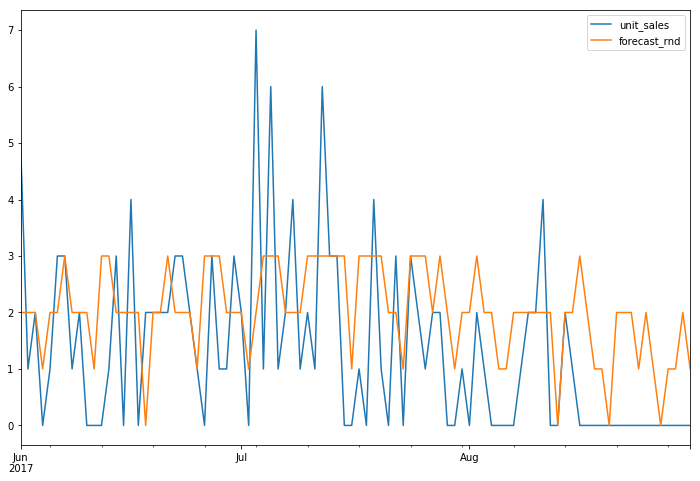

In [39]:
# 01/01/2018 - look at this one
temp_store_nbr = 1
temp_item_nbr = 1463610
temp_start_predict = 300  

# lowest AIC 
temp_ts_order=(0, 1, 1)
temp_ts_seasonal_order=(1, 1, 1, 14)

args = [[temp_store_nbr,temp_item_nbr,temp_ts_order,temp_ts_seasonal_order,temp_start_predict]]
optionalPlotFunctionTS = 1
parmDF = fn_attemptTimeSeriesParamConfig(args[0])
parmDF.head()

,store_nbr,item_nbr,data_present,model_order,model_seasonal_order,model_aic,mse_frcst,mse_frcst_rnd,sse_frcst,sse_frcst_rnd
0,1,1463610,YES,"(1, 0, 1)","(0, 1, 1, 7)",1460.417784,2.184906,2.533333,163.867922,190.000000


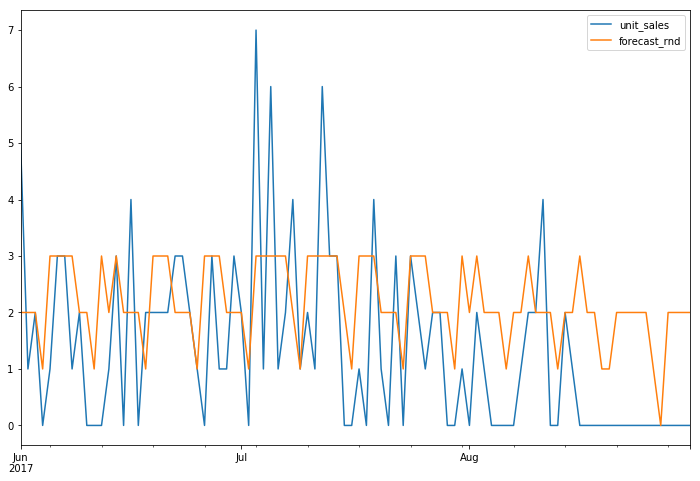

In [40]:
# 01/01/2018 - Lowest MSE
temp_ts_order=(1, 0, 1)
temp_ts_seasonal_order=(0, 1, 1, 7)
args = [[temp_store_nbr,temp_item_nbr,temp_ts_order,temp_ts_seasonal_order,temp_start_predict]]
optionalPlotFunctionTS = 1
parmDF = fn_attemptTimeSeriesParamConfig(args[0])
parmDF.head()

In [41]:
# 01/01/2018 - end with SHIFT Parameters

In [42]:
# Trouble-shooting errors with specific parameters after a long run

In [43]:
# 1st test of the function (was done before assigning to the massive loops above)
temp_store_nbr = 1
temp_item_nbr = 96995
#temp_ts_order=(1,2,0)
temp_ts_order=(1,1,0)
# temp_ts_seasonal_order=(1,1,1,7)
temp_ts_seasonal_order=(0,0,0,14)
temp_start_predict = 300  

# Have to pack this into an array to pass in via a single argument.
args = [[temp_store_nbr,temp_item_nbr,temp_ts_order,temp_ts_seasonal_order,temp_start_predict]]
#print('args1')
#print(args)
#print('\n')

optionalPlotFunctionTS = 0
parmDF = fn_attemptTimeSeriesParamConfig(args[0])
#parmDF.head()

# 7 - will break
# 31 - will work
#print('\n args2')
args2 = fn_concat_args(1, 96995, (1,1,1), (1,1,1,31), 300)
parmDF2 = fn_attemptTimeSeriesParamConfig(args2[0])
#print(args2)
#print('\n')

# Errored
args3 = fn_concat_args(1, 96995, (1,1,1), (1,1,1,7), 300)
parmDF3 = fn_attemptTimeSeriesParamConfig(args3[0])

# Errored
args4 = fn_concat_args(1, 96995, (0,0,0), (0,0,0,3), 300)
parmDF4 = fn_attemptTimeSeriesParamConfig(args3[0])


finalDF = parmDF
finalDF = finalDF.append(parmDF2)
finalDF = finalDF.append(parmDF3)

#finalDF = pd.concat(parmDF, parmDF2)
finalDF.head()


,store_nbr,item_nbr,data_present,model_order,model_seasonal_order,model_aic,mse_frcst,mse_frcst_rnd,sse_frcst,sse_frcst_rnd
0,1,96995,YES,"(1, 1, 0)","(0, 0, 0, 14)",473.693662,0.572426,1.000000,42.931973,75.000000
0,1,96995,YES,"(1, 1, 1)","(1, 1, 1, 31)",396.458262,0.413551,0.960000,31.016297,72.000000
0,1,96995,YES,"(1, 1, 1)","(1, 1, 1, 7)",363.590443,0.385383,0.960000,28.903748,72.000000


In [44]:
# Looking over the oil exports (which are highly correlated with grocery sales).  Ran out of time to implement

In [45]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,nan
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
4,2013-01-07,93.200000


In [46]:
df_holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [47]:
df_oil.set_index('date')
df_holiday.set_index('date')
print('done')

done


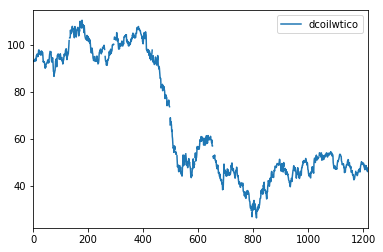

In [48]:
df_oil.plot()

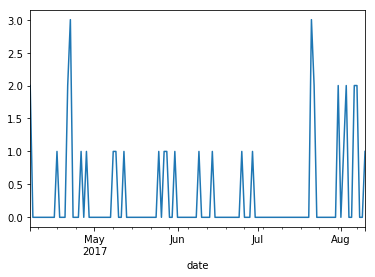

In [49]:
sample1['unit_sales'].plot()

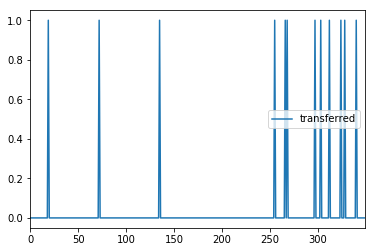

In [50]:
df_holiday.plot()